In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])
train_data = datasets.MNIST(root='./.data', transform=transform, train=True, download=True)
test_data = datasets.MNIST(root='./.data', transform=transform, train=False, download=True)


In [21]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)

train_device = []
for x, y in train_loader:
    train_device.append((x.to(device), y.to(device)))
test_device = []
for x, y in test_loader:
    test_device.append((x.to(device), y.to(device)))

In [22]:
from torch import nn
import torch

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x).flatten(start_dim=1)
        return self.layer3(x)
    
model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [23]:
from torch.optim import Optimizer

def train(model: nn.Module, train_device, optimizer: Optimizer, criterion, train_size) -> tuple[float, float]:
    train_loss = 0
    train_accuracy = 0.0
    model.train()
    for images, labels in train_device:
        optimizer.zero_grad()
        predictions = model(images)
        c_loss = criterion(predictions, labels)
        c_loss.backward()
        optimizer.step()
        train_loss += c_loss.item() * images.shape[0]
        train_accuracy += (predictions.argmax(dim = 1) == labels).sum().item()
    return train_loss / train_size, train_accuracy / train_size

def test(model: nn.Module, test_device, criterion, test_size)  -> tuple[float, float]:
    test_loss, test_accuracy = 0, 0
    model.eval()
    for images, labels in test_device:
        predictions = model(images)
        c_loss = criterion(predictions, labels)
        test_loss += c_loss.item() * images.shape[0]
        test_accuracy += (predictions.argmax(dim = 1) == labels).sum().item()
    return test_loss / test_size, test_accuracy / test_size
    

In [25]:
from tqdm.notebook import tqdm

num_epochs = 50

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in tqdm(range(num_epochs), total=num_epochs):
    train_loss, train_accuracy = train(model, train_device, optimizer, criterion, train_size)
    test_loss, test_accuracy = test(model, test_device, criterion, test_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

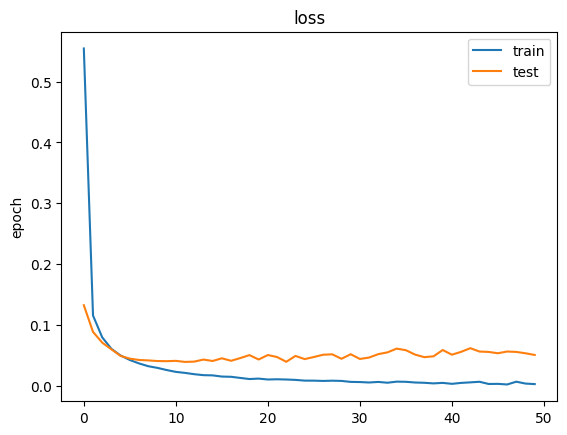

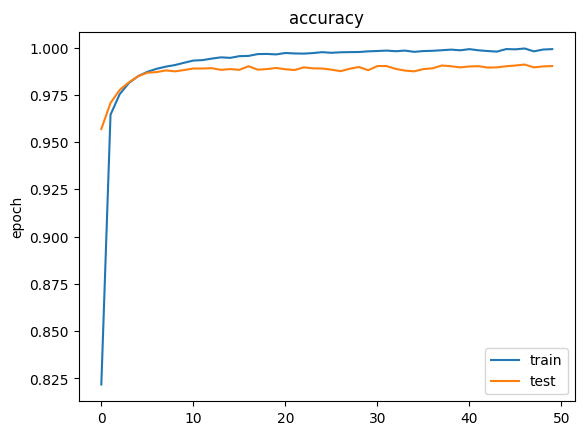

In [26]:
import matplotlib.pyplot as plt

epochs = range(num_epochs)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.title('loss')
plt.ylabel('epoch')
plt.legend()
plt.show()
plt.plot(epochs, train_accuracies, label='train')
plt.plot(epochs, test_accuracies, label='test')
plt.title('accuracy')
plt.ylabel('epoch')
plt.legend()
plt.show()

In [27]:
print('train loss', train_losses[-1])
print('test loss', test_losses[-1])
print('train accuracy', train_accuracies[-1])
print('test accuracy', test_accuracies[-1])

train loss 0.0024009202356349607
test loss 0.05032502442205089
train accuracy 0.9991666666666666
test accuracy 0.9902
